# Grid

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
partition = np.arange(0, 10.1, 0.1)
partition2 = np.arange(-math.pi, math.pi+(2*math.pi/30), 2*math.pi/30)
intervalls = np.column_stack((partition[:-1], partition[1:]))
intervalls2 = np.column_stack((partition2[:-1], partition2[1:]))
cells = np.array([[[[intervalls[i], intervalls[j], intervalls2[h]] for i in range(len(intervalls))] for j in range(len(intervalls))] for h in range(len(intervalls2))])
etatsSymbolique = {(j,i,h) : cells[h,i,j] for i in range(len(intervalls)) for j in range(len(intervalls)) for h in range(len(intervalls2))}


In [ ]:
states = list(etatsSymbolique.keys())
n_states = len(states)

state_to_idx = {s: idx for idx, s in enumerate(states)}
idx_to_state = states

In [ ]:
def getEtatsSymboliques(x1, x2, x3):
  x = int(10*x1)
  y = int(10*x2)
  z = 29
  for i in range(len(intervalls2)):
    if (x3 >= intervalls2[i][0] and x3 < intervalls2[i][1]):
      z = i
  return (x,y,z)


# Transition function

In [ ]:
inputs = [(i,j) for i in [0.25, 0.625, 1] for j in [-1, -0.5, 0, 0.5, 1]]

n_inputs = len(inputs)
input_to_idx = {inp: i for i, inp in enumerate(inputs)}

w_ = [0, 0, 0]
deltaW = np.array([0.05, 0.05, 0.05])

def f(x_, input1, input2, w_):
  x1 = x_[0] + input1 * math.cos(x_[2]) + w_[0]
  x2 = x_[1] + input1 * math.sin(x_[2]) + w_[1]
  x3 = (x_[2] + input2 + w_[2]) % (2*math.pi)
  return np.array([x1, x2, x3])

def geTo(i, j, h, u1, u2):
  x1min = etatsSymbolique[(i,j,h)][0][0]
  x1max = etatsSymbolique[(i,j,h)][0][1]
  x2min = etatsSymbolique[(i,j,h)][1][0]
  x2max = etatsSymbolique[(i,j,h)][1][1]
  x3min = etatsSymbolique[(i,j,h)][2][0]
  x3max = etatsSymbolique[(i,j,h)][2][1]
  x_ = [(x1max+x1min)/2, (x2max+x2min)/2, (x3max+x3min)/2]
  deltaX = np.array([(x1max - x1min)/2, (x2max - x2min)/2, (x3max - x3min)/2])
  Dx = np.array([[1, 0, 1],[0, 1, 1],[0, 0, 1]])
  Dw = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])


  fRes = f(x_, u1, u2, w_)
  fmin = fRes - Dx@deltaX - Dw@deltaW
  fmax = fRes + Dx@deltaX + Dw@deltaW

  resX1min = fmin[0]
  resX1max = fmax[0]
  resX2min = fmin[1]
  resX2max = fmax[1]
  resX3min = fmin[2]
  resX3max = fmax[2]

  if resX1max < 0 or resX1min >= 10 or resX2max < 0 or resX2min >= 10 or resX3max <partition2[0] or resX3min >= partition2[-1]:
    return []
  if resX1max >= 10: resX1max = 9.9995
  if resX1min < 0: resX1min = 0
  if resX2max >= 10: resX2max = 9.9995
  if resX2min < 0: resX2min = 0
  if resX3max >= partition2[-1]: resX3max = partition2[-1]-0.0005
  if resX3min < partition2[0]: resX3min = partition2[0]+0.0005
  res = []

  bornes = []
  for h in [resX3min, resX3max]:
    for j in [resX2min, resX2max]:
      for i in [resX1min, resX1max]:
        bornes.append(getEtatsSymboliques(i,j,h))
  for i in range(bornes[0][0], bornes[1][0]+1):
    for j in range(bornes[0][1], bornes[2][1]+1):
      for h in range(bornes[0][2], bornes[4][2]+1):
        res.append((i, j, h))
  return res

# Specification de surete

In [ ]:
from tqdm import tqdm

succs = [[frozenset() for _ in range(n_inputs)] for _ in range(n_states)]

for s_idx, (j, i, h) in tqdm(enumerate(states), total=n_states, desc="Precomputing successors"):
    for u_idx, (u1, u2) in enumerate(inputs):
        # You already have geTo, just reuse it:
        # temp is a list of successor states as (j', i', h') like in your code
        temp = geTo(j, i, h, u1, u2)
        if not temp:
            continue
        # Map successors to indices
        succ_idx = [state_to_idx[s] for s in temp if s in state_to_idx]
        if succ_idx:
            succs[s_idx][u_idx] = frozenset(succ_idx)


Precomputing successors: 100%|██████████| 300000/300000 [07:38<00:00, 654.14it/s] 


In [ ]:
def Pre_fast(R_idx_set):
    """
    R_idx_set: set of state indices (ints) that are in R
    returns: list of state indices that are predecessors of R
    """
    res = []
    for s_idx in range(n_states):
        # Try each input; if at least ONE input has all successors in R, s_idx is in Pre(R)
        for u_idx in range(n_inputs):
            succ_set = succs[s_idx][u_idx]
            if not succ_set:
                continue  # no successors for this input
            # Check if ALL successors are inside R
            # using the set operation succ_set <= R_idx_set
            if succ_set.issubset(R_idx_set):
                res.append(s_idx)
                break  # no need to check other inputs for this state
    return res




In [ ]:
def pointFixe_fast(Q_states):
    """
    Q_states: iterable of (j,i,h) states (like your original Q)
    returns: list of (j,i,h) states belonging to the fixed point.
    """
    # 1) Encode Q as indices
    Q_idx = {state_to_idx[s] for s in Q_states}

    # 2) Fixed point: R_{k+1} = Pre(R_k) ∩ Q
    R0 = set(Q_idx)
    while True:
        pre = Pre_fast(R0)
        R1 = {i for i in pre if i in Q_idx}
        if R1 == R0:
            break
        R0 = R1

    # 3) Decode back to (j,i,h)
    return [idx_to_state[i] for i in R0]


In [ ]:
borneXmin = 3
borneXmax = 7
borneYmin = 3
borneYmax = 7
res = []
bornes = []
for z in [partition2[0], partition2[-1]]:
  for y in [borneYmin, borneYmax]:
    for x in [borneXmin, borneXmax]:
      bornes.append(getEtatsSymboliques(x,y,z))

for i in range(bornes[0][0], bornes[1][0]+1):
    for j in range(bornes[0][1], bornes[2][1]+1):
        for h in range(bornes[0][2], bornes[4][2]+1):
          if i<0 or i>=100 or j<0 or j>=100 or h<0 or h>=30:
              continue
          res.append((i,j,h))
res = set(res)
Qs = [x for x in etatsSymbolique.keys() if x not in res]


In [ ]:
safe_set = pointFixe_fast(Qs)  # where Q is your original list of symbolic states


# Controlleur symbolique

In [ ]:
import random
controlleur = {}
R_star = safe_set   # or whatever name you use
# Convert safe set to indices
R_star_idx = {state_to_idx[s] for s in R_star}

controlleur = {}

for s in R_star:
    s_idx = state_to_idx[s]           # integer index of this symbolic state
    allowed_inputs = []               # will store inputs that keep all successors inside R_star_idx

    for u_idx, inp in enumerate(inputs):
        succ_set = succs[s_idx][u_idx]    # precomputed successors

        if not succ_set:
            continue                     # no successor → useless input

        # check condition: all successors in R_star
        if succ_set.issubset(R_star_idx):
            allowed_inputs.append(inp)

    controlleur[s] = allowed_inputs

def move(x, y, z, epoches):
    # 1) get starting symbolic state
    startState = getEtatsSymboliques(x, y, z)   # (j, i, h)

    # 2) start index
    s_idx = state_to_idx[startState]

    # 3) record visited states
    setOfStates = [startState]

    for _ in range(epoches):

        # --- Choose a safe input from the optimized controller ---
        input_choice = random.choice(controlleur[startState])
        u_idx = inputs.index(input_choice)   # input index

        # --- Choose a random successor using precomputed succs ---
        succ_indices = list(succs[s_idx][u_idx])   # frozenset → list
        if not succ_indices:
            break  # no move possible

        s_idx = random.choice(succ_indices)   # pick a successor index
        startState = idx_to_state[s_idx]       # convert back to (j,i,h)

        setOfStates.append(startState)

    return setOfStates


In [ ]:
res = [[a,b] for a,b,c in res]

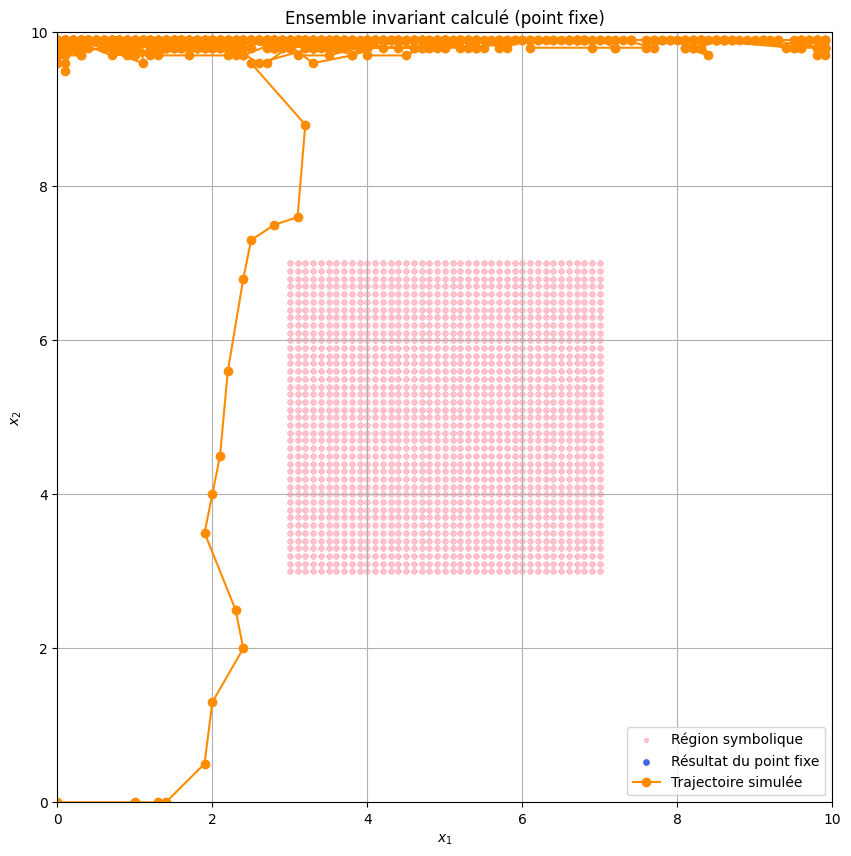

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

trajectoire  = move(0,0,0, 1000)
fig, ax = plt.subplots(figsize=(10, 10))

if len(res) > 0:

    res_arr = np.array(res)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='pink', label='Région symbolique')

if len(trajectoire) > 0:
    traj_x = [s[0] / 10 for s in trajectoire]
    traj_y = [s[1] / 10 for s in trajectoire]



    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectoire)
    ax.scatter(traj_arr[:, 0] / 10, traj_arr[:, 1] / 10,
               s=15, color='royalblue', label='Résultat du point fixe')

    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")

# specification d'atteignabilite

In [ ]:
def pointFixeAtteignabilité_fast(Q_states):
    """
    Q_states: list of (j,i,h) states that we want to reach (target set)
    Returns: controller dict {state_tuple: [allowed_inputs]}
    """


    # ---------- Convert input Q to indices ----------
    Q_idx = {state_to_idx[s] for s in Q_states}

    # controller indexed by state index internally
    controlleur_idx = {}

    # ---------- INITIALIZATION ----------
    R0 = set(Q_idx)

    # Pre(R0)
    pre0 = Pre_fast(R0)

    # R1 = Q ∪ Pre(Q)
    R1 = R0.union(pre0)

    # Initialize controller for all states in R1 \ Q
    for s_idx in R1:
        if s_idx not in Q_idx:   # only states that are not targets
            if s_idx not in controlleur_idx.keys():
                controlleur_idx[s_idx] = []
            for u_idx, inp in enumerate(inputs):
                succ_set = succs[s_idx][u_idx]
                if succ_set and succ_set.issubset(R0):
                    controlleur_idx[s_idx].append(inp)

    # ---------- FIXED-POINT LOOP ----------
    while R1 != R0:

        R0 = set(R1)

        # Pre(R0)
        pre0 = Pre_fast(R0)

        # R1 = Q ∪ Pre(prev)
        R1 = R0.union(pre0)

        # For new states in R1 \ Q, add controller entries
        for s_idx in R1:
            if s_idx not in Q_idx and s_idx not in controlleur_idx.keys():
                controlleur_idx[s_idx] = []
                for u_idx, inp in enumerate(inputs):
                    succ_set = succs[s_idx][u_idx]
                    if succ_set and succ_set.issubset(R0):
                        controlleur_idx[s_idx].append(inp)

    # ---------- Convert state indices back to (j,i,h) tuples ----------
    controlleur = {
        idx_to_state[s_idx]: inputs_list
        for s_idx, inputs_list in controlleur_idx.items()
    }

    return controlleur


In [1]:
borneXmin = 3
borneXmax = 7
borneYmin = 3
borneYmax = 7
resAtteint = []
bornes = []
for z in [partition2[0], partition2[-1]]:
  for y in [borneYmin, borneYmax]:
    for x in [borneXmin, borneXmax]:
      bornes.append(getEtatsSymboliques(x,y,z))

for i in range(bornes[0][0], bornes[1][0]+1):
    for j in range(bornes[0][1], bornes[2][1]+1):
        for h in range(bornes[0][2], bornes[4][2]+1):
          if i<0 or i>=100 or j<0 or j>=100 or h<0 or h>=30:
              continue
          resAtteint.append((i,j,h))
resAtteint = set(resAtteint)
res = [[a,b] for a,b,c in resAtteint]

In [ ]:
controlleurAtteint = pointFixeAtteignabilité_fast(resAtteint)

{(71, 43, 0): [(0.625, -1), (0.625, -0.5), (0.625, 0), (1, -1), (1, -0.5), (1, 0)], (71, 43, 1): [(0.625, -1), (0.625, -0.5), (1, -1), (1, -0.5)], (71, 43, 2): [(0.625, -1), (0.625, -0.5), (1, -1), (1, -0.5)], (71, 43, 3): [(0.625, -1), (1, -1)], (71, 43, 4): [(0.625, -1), (1, -1)], (71, 43, 5): [(1, -1)], (71, 43, 24): [(1, -1), (1, -0.5), (1, 0), (1, 0.5), (1, 1)], (71, 43, 25): [(0.625, -1), (0.625, -0.5), (0.625, 0), (0.625, 0.5), (0.625, 1), (1, -1), (1, -0.5), (1, 0), (1, 0.5), (1, 1)], (71, 43, 26): [(0.625, -1), (0.625, -0.5), (0.625, 0), (0.625, 0.5), (1, -1), (1, -0.5), (1, 0), (1, 0.5)], (71, 43, 27): [(0.625, -1), (0.625, -0.5), (0.625, 0), (0.625, 0.5), (1, -1), (1, -0.5), (1, 0), (1, 0.5)], (71, 43, 28): [(0.625, -1), (0.625, -0.5), (0.625, 0), (1, -1), (1, -0.5), (1, 0)], (71, 43, 29): [(0.625, -1), (0.625, -0.5), (0.625, 0), (1, -1), (1, -0.5), (1, 0)], (72, 43, 0): [(0.625, -1), (0.625, -0.5), (0.625, 0), (1, -1), (1, -0.5), (1, 0)], (72, 43, 1): [(0.625, -1), (0.625, 

In [ ]:
import random

R_target = resAtteint

    # convert targets to indices
R_target_idx = {state_to_idx[s] for s in R_target}

    # pick a start
start = (1,5,4)
start_idx = state_to_idx[start]

trajectory = [start]

visited = set([start_idx])   # to detect cycles

while True:

        inp = random.choice(controlleurAtteint[start])
        u_idx = input_to_idx[inp]

        succ_set = succs[start_idx][u_idx]
        if not succ_set:
            print("No successors → stopping.")
            break

        next_idx = random.choice(list(succ_set))
        next_state = idx_to_state[next_idx]

        trajectory.append(next_state)

        # STOP CONDITION (correct one)
        if next_idx in R_target_idx:
            print("Target reached.")
            break

        # CYCLE DETECTION → prevents infinite loops
        if next_idx in visited:
            print("Cycle detected → stopping.")
            break

        visited.add(next_idx)

        # move
        start = next_state
        start_idx = next_idx

Target reached.


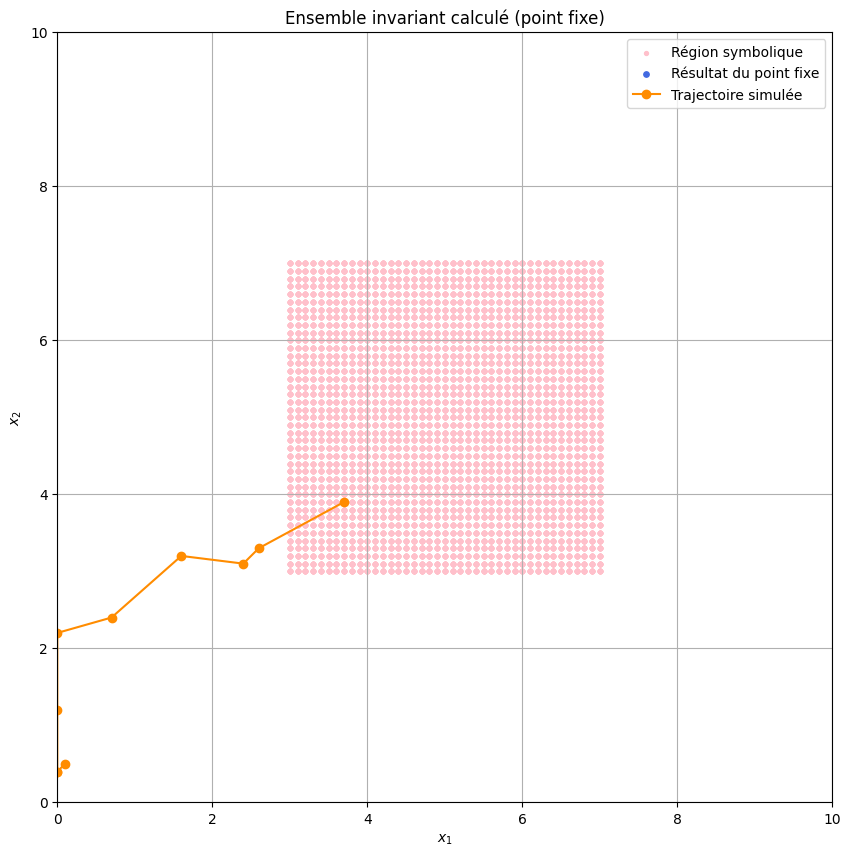

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

if len(res) > 0:
    res_arr = np.array(res)
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='pink', label='Région symbolique')

# If trajectoire is a list of points [(x1, y1), (x2, y2), ...]
if len(trajectory) > 0:
    traj_x = [s[0] / 10 for s in trajectory]
    traj_y = [s[1] / 10 for s in trajectory]


    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectory)
    ax.scatter(traj_arr[:, 0] / 10, traj_arr[:, 1] / 10,
               s=15, color='royalblue', label='Résultat du point fixe')

    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("'trajectoire' is empty — nothing to plot.")

# Spécification basée sur les automates

In [ ]:
automate = {
    "a":{0:"a",1:"b",2:"c",3:"a",4:"e"},
    "b":{0:"b",1:"b",2:"e",3:"d",4:"e"},
    "c":{0:"c",1:"e",2:"c",3:"d",4:"e"},
    "d":{0:"d",1:"d",2:"d",3:"d",4:"d"},
    "e":{0:"e",1:"e",2:"e",3:"e",4:"e"}
  }

In [ ]:
def area(Xmin,Xmax,Ymin,Ymax):
  borneXmin = Xmin
  borneXmax = Xmax
  borneYmin = Ymin
  borneYmax = Ymax
  res = []
  bornes = []
  for z in [-math.pi, math.pi]:
    for y in [borneYmin, borneYmax]:
      for x in [borneXmin, borneXmax]:
        bornes.append(getEtatsSymboliques(x,y,z))

  for i in range(bornes[0][0], bornes[1][0]+1):
      for j in range(bornes[0][1], bornes[2][1]+1):
          for h in range(bornes[0][2], bornes[4][2]+1):
            if i<0 or i>=100 or j<0 or j>=100 or h<0 or h>=30:
                continue
            res.append((i,j,h))
  res = set(res)
  return res

In [ ]:
Q1 = area(1,4.5,6,9)
Q2 = area(5.5,9.5,0.5,4)
Q3 = area(5,9.5,4.5,9.5)
Q4 = area(3,3.5,2,2.5)

setQ1 = set(Q1); setQ2 = set(Q2); setQ3 = set(Q3); setQ4 = set(Q4)

Q0 = [x for x in etatsSymbolique.keys() if (x not in setQ1 and x not in setQ2 and x not in setQ3 and x not in setQ4)]

In [2]:
def labelisation(etat):
  if etat in setQ1: return 1
  if etat in setQ2: return 2
  if etat in setQ3: return 3
  if etat in setQ4: return 4
  return 0

def h1(state,etat):
  return automate[state][labelisation(etat)]

In [3]:
space = [(state,etat) for state in ["a","b","c","d","e"] for etat in etatsSymbolique.keys() ]

def g(state,etat,input):
  res = []

  for etat_successeur in succs[state_to_idx[etat]][input_to_idx[input]]:
    res.append((h1(state,idx_to_state[etat_successeur]),idx_to_state[etat_successeur]))
  return res

# sythèse du controlleur

In [4]:
pointFixeAtteignabilité_fast()

In [ ]:
controlleur_automate = {}
def predecessueur(R):
  res = []
  Rset = set(R)
  for state,etat in space:
    if (state,etat) in controlleur_automate:
      continue
    taken = False
    for input in inputs:
      temp = g(state,etat,input)
      if not temp:
        continue
      if all([x in Rset for x in temp]):
        if not taken:
          res.append((state,etat))
          controlleur_automate[(state,etat)] = [input]
          taken = True;
        else:
          controlleur_automate[(state,etat)].append(input)

  return res

In [5]:
def point_fixe_automate(Q):
  R0 = Q
  prede = predecessueur(R0)
  R1 = prede+R0
  while R1!=R0:
    R0 = R1
    prede = predecessueur(R0)
    R1 = R0+prede
  return R1

Q0 = point_fixe_automate([etat for etat in space if etat[0]=="d"])
def h2(state,etat):
  return controlleur_automate[(state,etat)]

In [6]:
for x in controlleur_automate.keys():
  if x[0] == "a" and x[1][0]>=70:
    print(x)

In [ ]:
import random
trajectoire_automate = [(72, 0, 0)]
etat = ('c', (72, 0, 0))


while etat[0] != "d":
  input = random.choice(h2(etat[0], etat[1]))
  etat = random.choice(g(etat[0],etat[1],input))
  trajectoire_automate.append(etat[1])
print(trajectoire_automate)

[(72, 0, 0), (60, 0, 29), (48, 3, 28), (40, 5, 26), (31, 10, 29)]


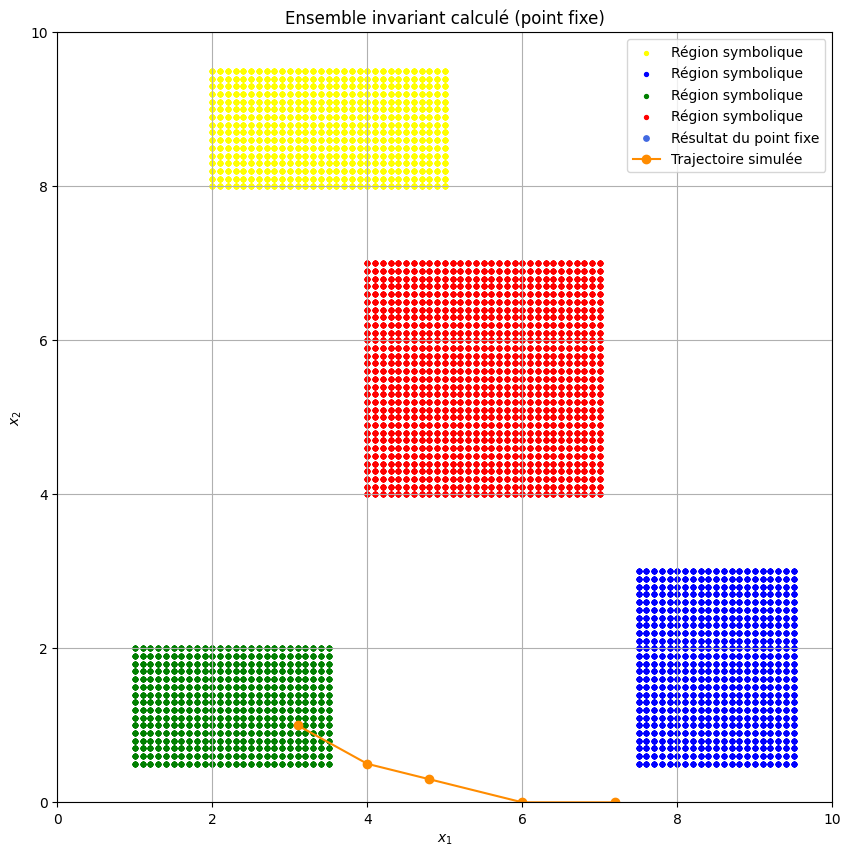

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))

if len(Q1) > 0:
    res_arr = np.array([[a,b] for a,b,c in Q1])
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='yellow', label='Région symbolique')

if len(Q2) > 0:
    res_arr = np.array([[a,b] for a,b,c in Q2])
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='blue', label='Région symbolique')

if len(Q3) > 0:
    res_arr = np.array([[a,b] for a,b,c in Q3])
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='green', label='Région symbolique')

if len(Q4) > 0:
    res_arr = np.array([[a,b] for a,b,c in Q4])
    ax.scatter(res_arr[:, 0] / 10, res_arr[:, 1] / 10, s=8, color='red', label='Région symbolique')



trajectoire_automate = [[a,b] for a,b,c in trajectoire_automate]
# If trajectoire is a list of points [(x1, y1), (x2, y2), ...]
if len(trajectoire_automate) > 0:
    traj_x = [s[0] / 10 for s in trajectoire_automate]
    traj_y = [s[1] / 10 for s in trajectoire_automate]



    # Convert to NumPy array for convenience
    traj_arr = np.array(trajectoire_automate)
    ax.scatter(traj_arr[:, 0] / 10, traj_arr[:, 1] / 10,
               s=15, color='royalblue', label='Résultat du point fixe')

    if len(traj_x) > 1:
        ax.plot(traj_x, traj_y, '-o', color='darkorange', label='Trajectoire simulée')

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Ensemble invariant calculé (point fixe)')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("⚠️ 'trajectoire' is empty — nothing to plot.")